<a href="https://colab.research.google.com/github/Senthil-Riddhish/Data_Analysis_/blob/main/yolo_nas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [16]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
     

In [17]:
from IPython.display import clear_output

In [18]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


In [19]:
from super_gradients.training import models


In [20]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

In [5]:
!unzip -q /content/EEP_Detection-1.zip -d /content

In [6]:
dataset_params = {
    'data_dir':'/content/EEP_Detection-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['LDPE','HDPE','PETE','PP','PS','PVC']
}


In [7]:

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Caching annotations: 100%|██████████| 80/80 [00:00<00:00, 2834.80it/s]


In [8]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [9]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [10]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

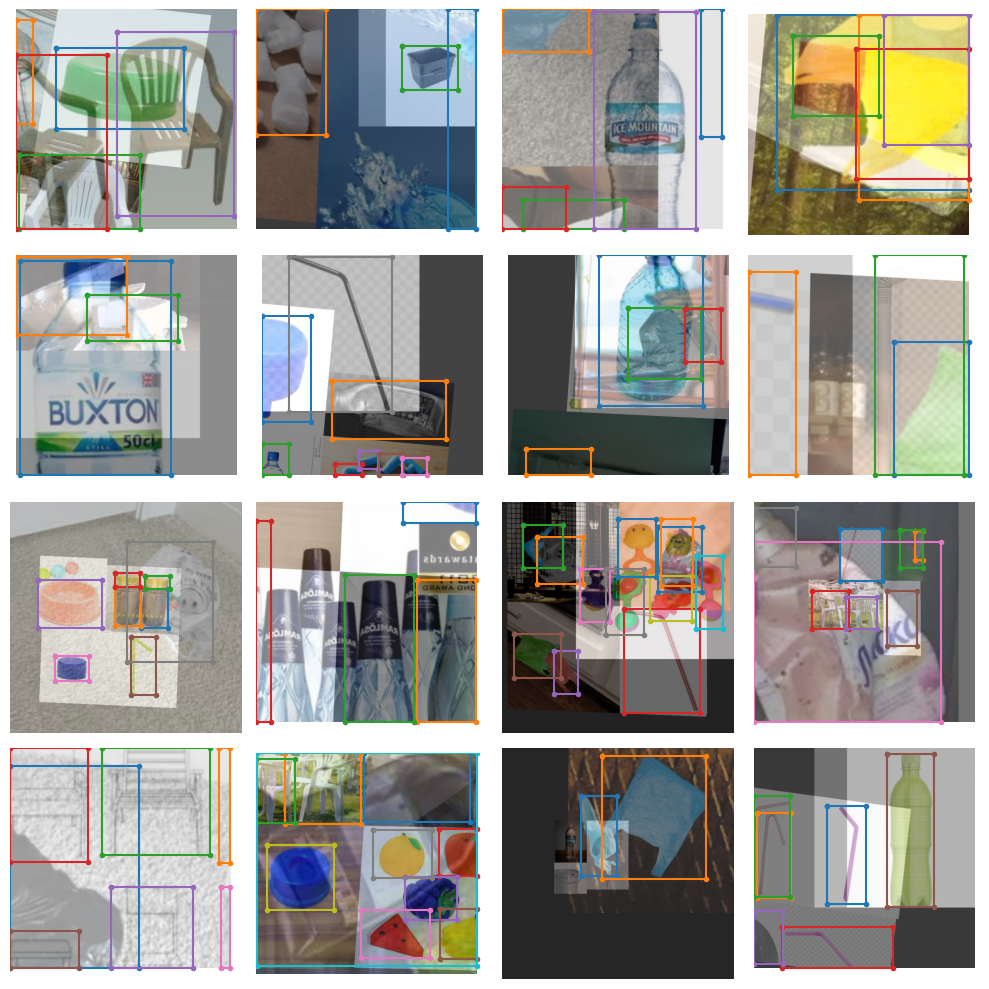

In [11]:
train_data.dataset.plot()

In [12]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-22 13:39:03] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

In [13]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [22]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-22 13:54:25] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/ppe_yolonas_run2/console_May22_13_54_26.txt


[2023-05-22 13:54:28] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1334       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         83         (len(train_loader))
    - Gradient updates per epoch:   83         (len(train_loader) / batch_accumulate)

[2023-05-22 13:56:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/ckpt_best.pth
[2023-05-22 13:56:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3043481111526489
[2023-05-22 14:01:50] INFO - base_sg_logger.py - Checkpoint saved in checkp

In [23]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints2/ppe_yolonas_run2/ckpt_best.pth")

[2023-05-22 14:15:47] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints2/ppe_yolonas_run2/ckpt_best.pth EMA checkpoint.


In [24]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test:  80%|████████  | 4/5 [00:02<00:00,  2.36it/s]

{'PPYoloELoss/loss_cls': 1.1397578,
 'PPYoloELoss/loss_iou': 0.15032336,
 'PPYoloELoss/loss_dfl': 1.1459501,
 'PPYoloELoss/loss': 2.0885413,
 'Precision@0.50': tensor(0.0311),
 'Recall@0.50': tensor(0.9717),
 'mAP@0.50': tensor(0.7513),
 'F1@0.50': tensor(0.0598)}

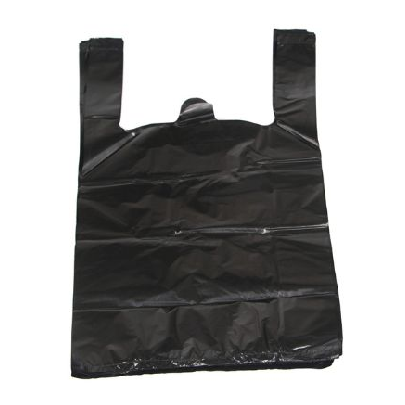

In [29]:
img_url = '/content/EEP_Detection-1/valid/images/LDPE (222).jpg'
best_model.predict(img_url).show()

In [51]:
input_video_path = f"/content/result (3).mp4"
output_video_path = "detections3.mp4"

In [52]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [53]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 2608/2608 [00:57<00:00, 45.72it/s]


In [39]:
!rm '/content/result_compressed.mp4'

NotImplementedError: ignored

In [35]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""

""" % data_url)

TypeError: ignored